<a href="https://colab.research.google.com/github/Hadhemyy/-Classification-of-Emotions-from-EEG-Brain-Signals/blob/main/Classification_of_Emotions_from_EEG_Brain_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Emotions from EEG Brain Signals using CNN**

In [1]:
!pip install imblearn
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.6 MB/s eta 0:00:00


In [2]:
# import libraries
import numpy as np
import random
import pandas as pd
#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_addons as tfa

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
#   Different layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

#   callbacks
from keras import callbacks
#   Optimizer
from tensorflow.keras.optimizers import SGD


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# upload google drive in our colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**data preprocessing and visualization**

In [4]:
#Reading data
data = pd.read_csv ("/content/drive/MyDrive/emotions.csv")
len(data)

2132

In [5]:
#Seprarting Positive,Neagtive and Neutral dataframes for plortting
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

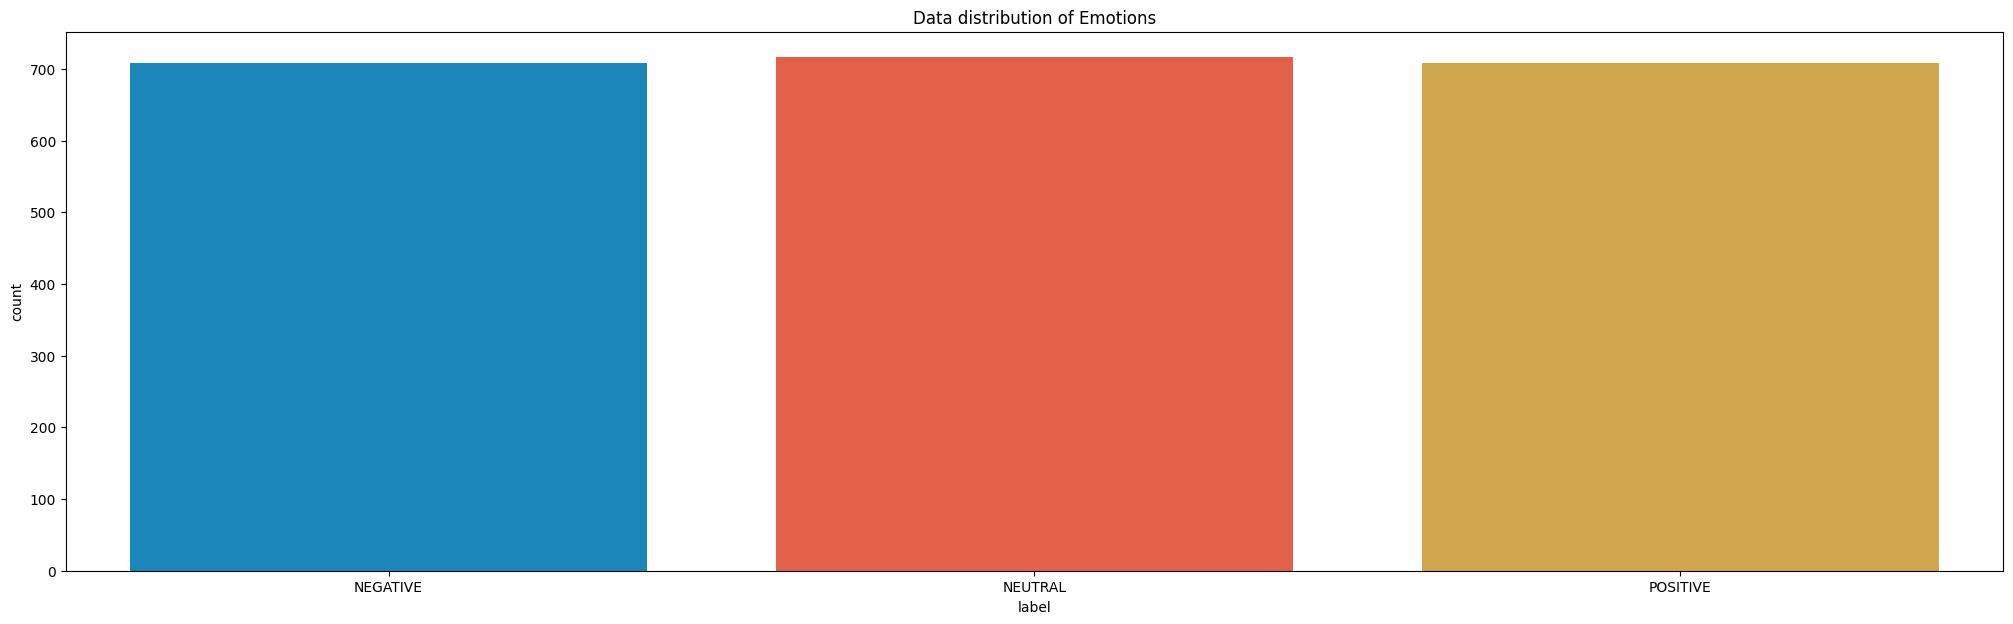

In [6]:
#plottintg Dataframe distribution
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

In [7]:
CLASSES = ['NEGATIVE',
           'NEUTRAL',
           'POSITIVE']

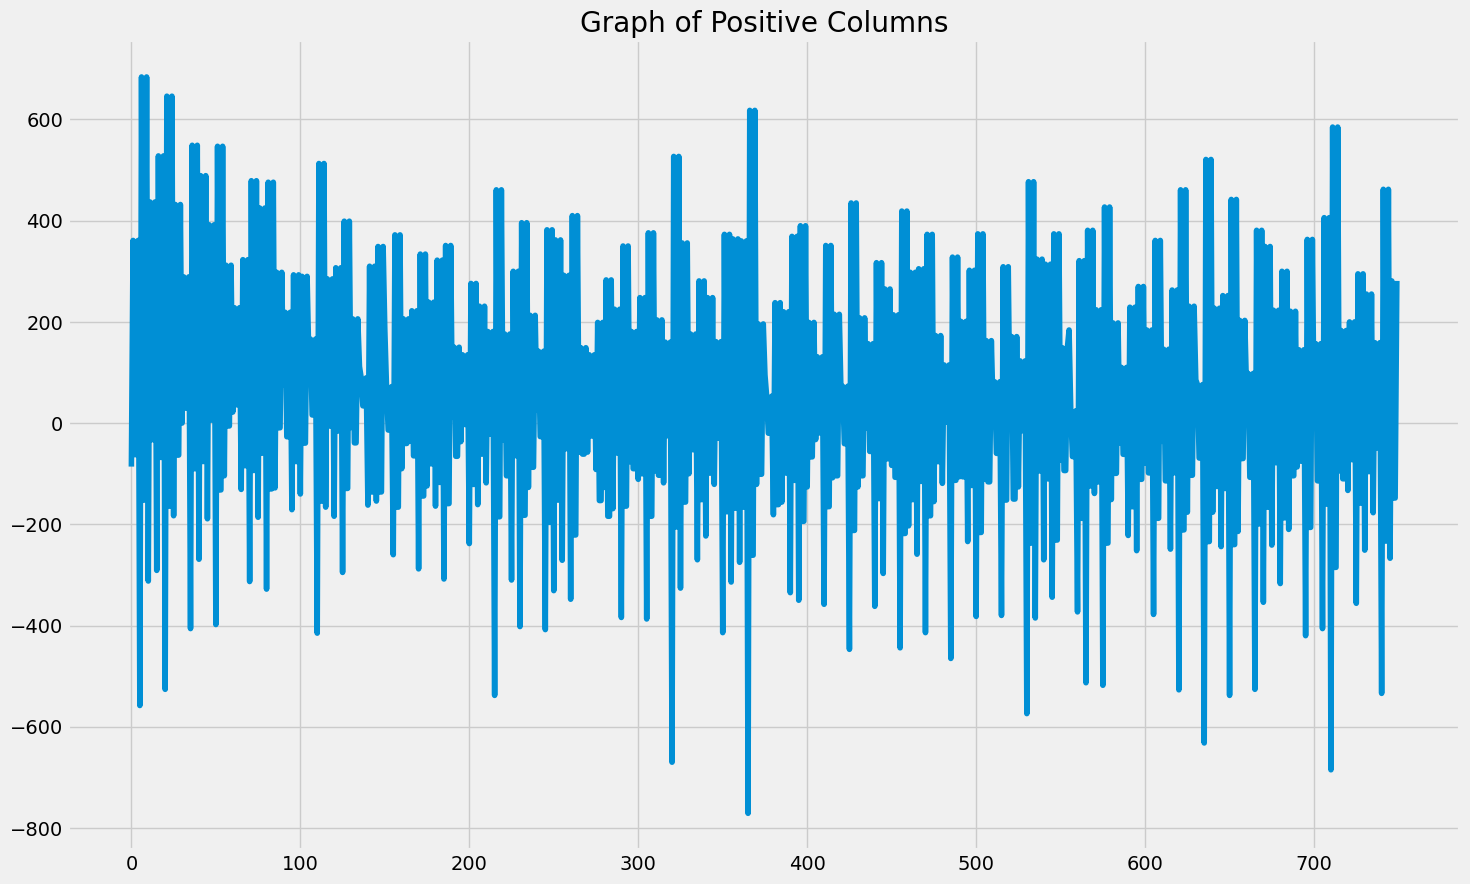

'As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'

In [8]:
#Plotting Positive DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'''

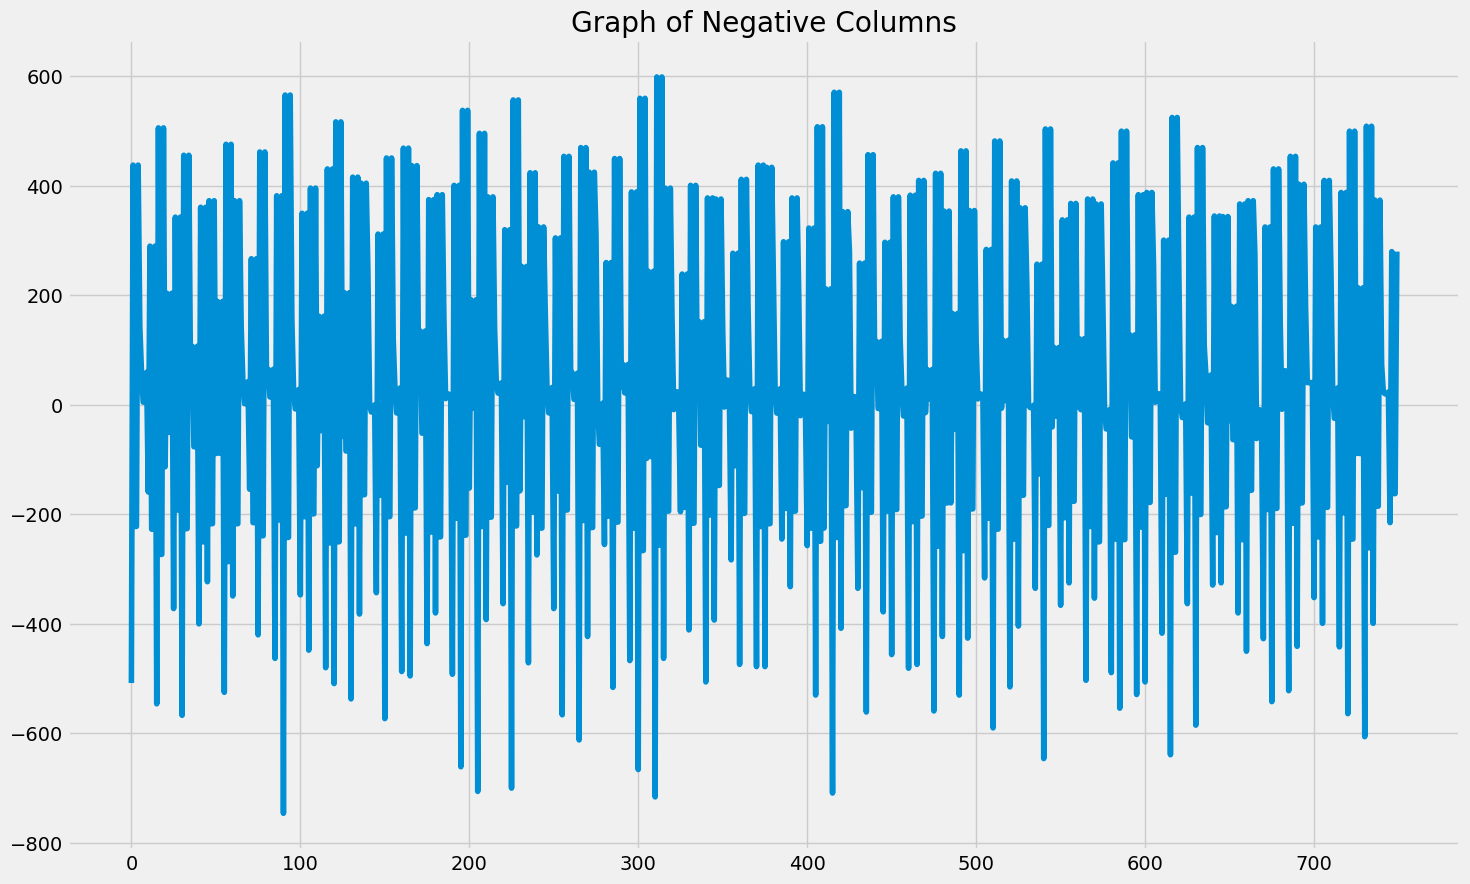

'As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'

In [9]:
#Plotting Negative DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'''


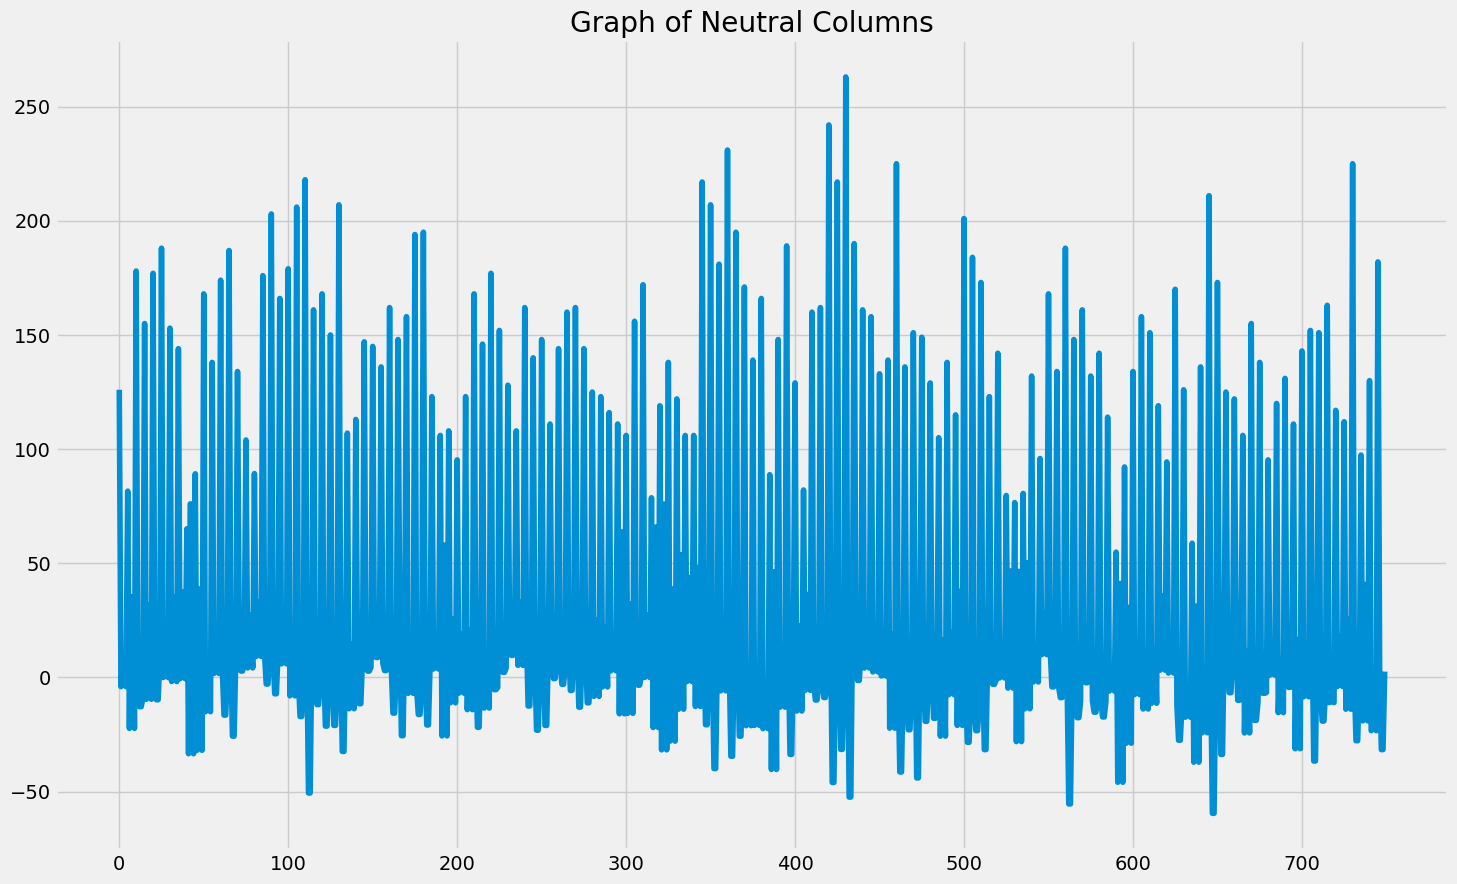

'As we can see the most of the Neutral Signals ae in between -50 to 250 '

In [10]:
#Plotting Neutral DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()
'''As we can see the most of the Neutral Signals ae in between -50 to 250 '''

In [11]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

In [12]:
#Calling above function and splitting dataset into train and test
X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [13]:
#checking shape of dataset
x_train.shape[1]

2548

# **CNN model**

In [14]:
# Creating a CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(2548, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes (NEUTRAL, POSITIVE, NEGATIVE)



In [15]:
### Model Compilation
model.compile(
    optimizer=SGD(learning_rate=0.01),
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


In [16]:
# Reshaping the input data to fit the model
x_train = x_train.reshape(x_train.shape[0], 2548, 1)  # Adjust the input shape
x_test = x_test.reshape(x_test.shape[0], 2548, 1)  # Adjust the input shape


In [17]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [18]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=16,
        epochs=40,
        validation_split=0.1,
        callbacks = CALLBACKS
    )

Epoch 1/40
96/96 [==============================] - 14s 13ms/step - loss: 0.6123 - acc: 0.7868 - auc: 0.9156 - precision: 0.8373 - recall: 0.7145 - val_loss: 0.3502 - val_acc: 0.8830 - val_auc: 0.9715 - val_precision: 0.8929 - val_recall: 0.8772 - lr: 0.0100
Epoch 2/40
96/96 [==============================] - 1s 6ms/step - loss: 0.3151 - acc: 0.8937 - auc: 0.9736 - precision: 0.8993 - recall: 0.8853 - val_loss: 0.2293 - val_acc: 0.9181 - val_auc: 0.9875 - val_precision: 0.9181 - val_recall: 0.9181 - lr: 0.0100
Epoch 3/40
96/96 [==============================] - 1s 6ms/step - loss: 0.2448 - acc: 0.9120 - auc: 0.9823 - precision: 0.9161 - recall: 0.9107 - val_loss: 0.2112 - val_acc: 0.9123 - val_auc: 0.9882 - val_precision: 0.9123 - val_recall: 0.9123 - lr: 0.0100
Epoch 4/40
96/96 [==============================] - 1s 6ms/step - loss: 0.2080 - acc: 0.9263 - auc: 0.9880 - precision: 0.9286 - recall: 0.9237 - val_loss: 0.1737 - val_acc: 0.9181 - val_auc: 0.9922 - val_precision: 0.9181 - va

In [19]:
### Evaluate Model
test_scores = model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[3] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[4] * 100))

14/14 [==============================] - 0s 5ms/step - loss: 0.1074 - acc: 0.9649 - auc: 0.9962 - precision: 0.9649 - recall: 0.9649


Testing Loss : 		 0.107364
Testing Accuracy : 	 96.487117 %
Testing AC : 		 99.620187 %
Testing Precision : 	 96.487117 %
Testing Recall : 	 96.487117 %


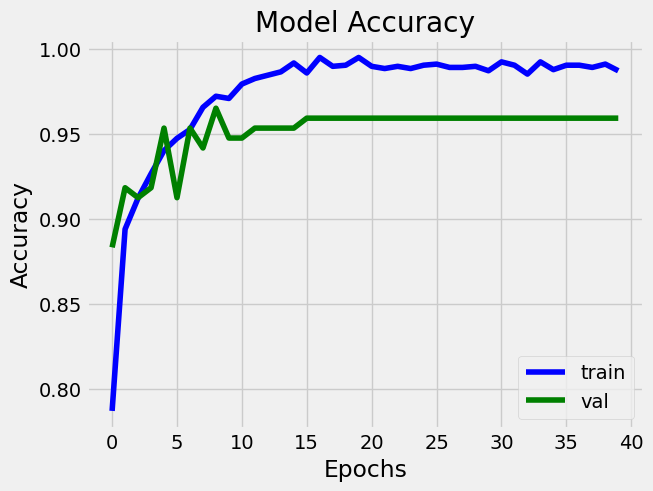

In [20]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

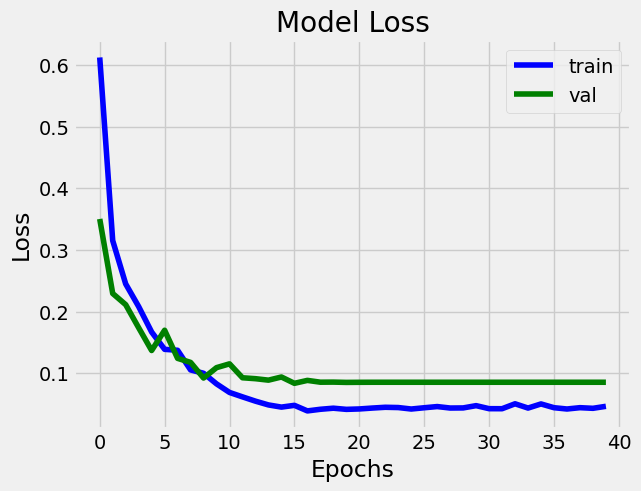

In [21]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

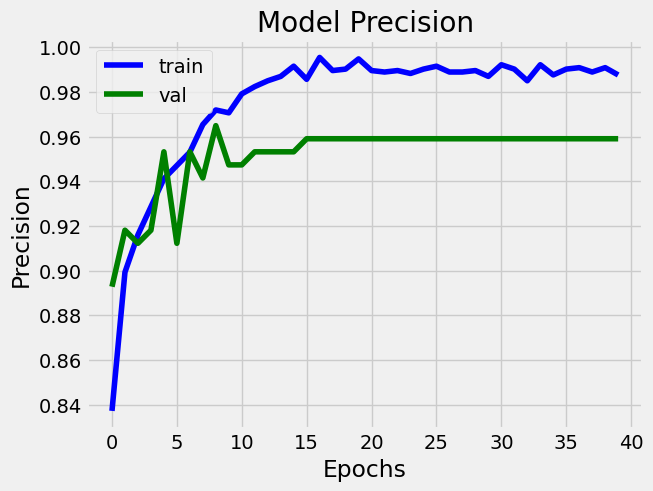

In [22]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

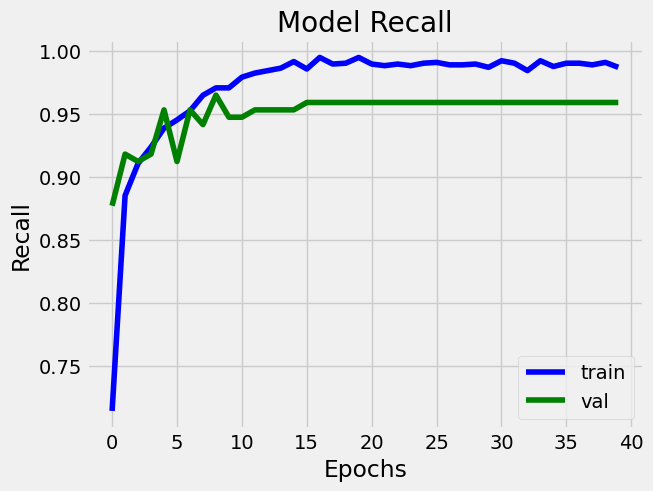

In [23]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [24]:
#Test set Evaluation
#Classification Report
#Confusion Matrix
#ROC Curve
#Extension ROC Multiclass
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))

14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    NEGATIVE       0.97      0.97      0.97       153
     NEUTRAL       0.95      0.94      0.95       142
    POSITIVE       0.97      0.98      0.97       132

   micro avg       0.96      0.96      0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427
 samples avg       0.96      0.96      0.96       427



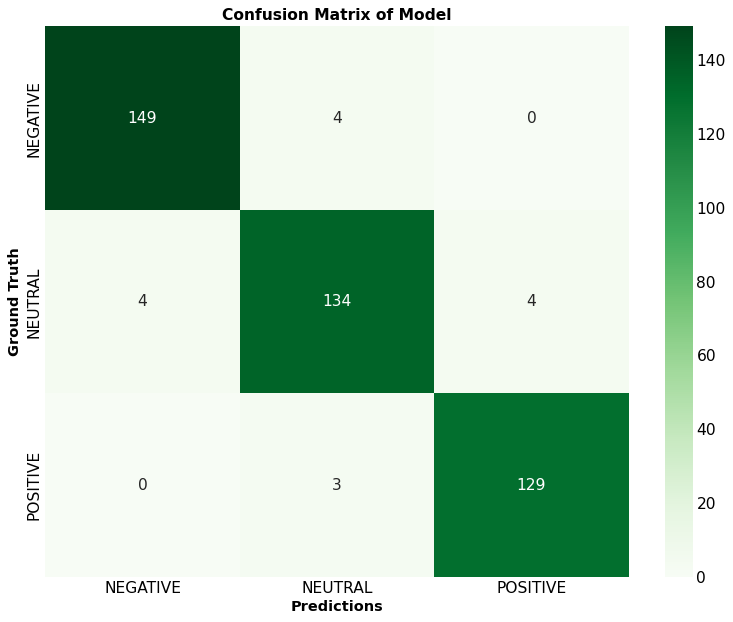

In [25]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)